In [ ]:
pip install pytorch_tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.7 MB/s eta 0:00:00


In [ ]:
import zipfile
import os
import cv2
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, log_loss, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, concatenate
from keras.callbacks import EarlyStopping
from google.colab import files
from PIL import Image

In [ ]:
# Unzip the compressed data
# Upload the zip file
uploaded = files.upload()

# Specify the name of the uploaded zip file and the destination directory
zip_file_name = 'archive (17).zip'
destination_directory = 'extraction_directory'

# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(destination_directory)

Saving archive (17).zip to archive (17).zip


In [ ]:
# Verify the number of images in the file path(s)
path1 = '/content/extraction_directory/train/REAL'
path2 = '/content/extraction_directory/train/FAKE'
path3 = '/content/extraction_directory/test/REAL'
path4 = '/content/extraction_directory/test/FAKE'

def count_files_in_directory(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)
    return count

count1 = count_files_in_directory(path1)
count2 = count_files_in_directory(path2)
count3 = count_files_in_directory(path3)
count4 = count_files_in_directory(path4)

print(f"Number of files in path 1: {count1}")
print(f"Number of files in path 2: {count2}")
print(f"Number of files in path 3: {count3}")
print(f"Number of files in path 4: {count4}")

Number of files in path 1: 50000
Number of files in path 2: 50000
Number of files in path 3: 10000
Number of files in path 4: 10000


In [ ]:
# Function to load images and convert to pixel intensity values
def load_images_and_convert_to_pixel_values(path):
    image_paths = [os.path.join(path, filename) for filename in os.listdir(path)]
    pixel_values = []

    for image_path in image_paths:
        print(image_path)
        image = cv2.imread(image_path)
        pixel_values.append(image.flatten())  # Flatten the image to a 1D array

    return np.array(pixel_values)

# Paths from above
path1_train = path1
path2_train = path2
path3_test = path3
path4_test = path4

# Load images and convert to pixel intensity values for the train set
real_train_images = load_images_and_convert_to_pixel_values(path1_train)
fake_train_images = load_images_and_convert_to_pixel_values(path2_train)

print('hit')

# Load images and convert to pixel intensity values for the test set
real_test_images = load_images_and_convert_to_pixel_values(path3_test)
fake_test_images = load_images_and_convert_to_pixel_values(path4_test)

# Create labels for train and test sets (0 for real, 1 for fake)
train_labels = [0] * (len(real_train_images)) + [1] * (len(fake_train_images))
test_labels = [0] * (len(real_test_images)) + [1] * (len(fake_test_images))

# Combine real and fake images for train and test sets
train_images = np.concatenate((real_train_images, fake_train_images), axis=0)
test_images = np.concatenate((real_test_images, fake_test_images), axis=0)

# Create DataFrames for train and test sets
train_data = {'Label': train_labels}
for i in range(train_images.shape[1]):
    pixel_label = f'Pixel_{i}'
    train_data[pixel_label] = train_images[:, i]

test_data = {'Label': test_labels}
for i in range(test_images.shape[1]):
    pixel_label = f'Pixel_{i}'
    test_data[pixel_label] = test_images[:, i]

# Create DataFrames
df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

# Export DataFrames to separate CSV files for train and test sets
# df_train.to_csv('/content/extraction_directory/train_set.csv', index=False)
# df_test.to_csv('/content/extraction_directory/test_set.csv', index=False)

Streaming output truncated to the last 5000 lines.
/content/extraction_directory/test/FAKE/930 (2).jpg
/content/extraction_directory/test/FAKE/844 (8).jpg
/content/extraction_directory/test/FAKE/762 (9).jpg
/content/extraction_directory/test/FAKE/689.jpg
/content/extraction_directory/test/FAKE/885 (8).jpg
/content/extraction_directory/test/FAKE/695 (5).jpg
/content/extraction_directory/test/FAKE/435 (3).jpg
/content/extraction_directory/test/FAKE/644 (8).jpg
/content/extraction_directory/test/FAKE/43 (10).jpg
/content/extraction_directory/test/FAKE/364 (2).jpg
/content/extraction_directory/test/FAKE/604 (4).jpg
/content/extraction_directory/test/FAKE/937 (2).jpg
/content/extraction_directory/test/FAKE/646 (6).jpg
/content/extraction_directory/test/FAKE/908 (6).jpg
/content/extraction_directory/test/FAKE/70 (10).jpg
/content/extraction_directory/test/FAKE/135 (10).jpg
/content/extraction_directory/test/FAKE/165 (4).jpg
/content/extraction_directory/test/FAKE/786 (10).jpg
/content/extrac

In [ ]:
# View df info
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 3073 entries, Label to Pixel_3071
dtypes: int64(1), uint8(3072)
memory usage: 293.7 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 3073 entries, Label to Pixel_3071
dtypes: int64(1), uint8(3072)
memory usage: 58.7 MB
None


In [ ]:
# Define the percentage of rows to select
percentage = 100 # Percentage of rows to select

# Calculate the number of rows to select
n_total_train = len(df_train)
n_select_train = int(percentage * n_total_train / 100)

n_total_test = len(df_test)
n_select_test = int(percentage * n_total_test / 100)

# Randomly sample rows with equal representation of the "Label" feature
def random_sample_with_equal_label_distribution(df, n_select):
    unique_labels = df['Label'].unique()
    rows_per_label = n_select // len(unique_labels)
    selected_rows = []

    for label in unique_labels:
        label_rows = df[df['Label'] == label]
        if len(label_rows) > rows_per_label:
            selected_rows.append(label_rows.sample(rows_per_label))
        else:
            selected_rows.append(label_rows)

    random.shuffle(selected_rows)
    return pd.concat(selected_rows)

selected_rows_train = random_sample_with_equal_label_distribution(df_train, n_select_train)
selected_rows_test = random_sample_with_equal_label_distribution(df_test, n_select_test)

In [ ]:
# View the subset info

print(selected_rows_train.info())
print(selected_rows_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Columns: 3073 entries, Label to Pixel_3071
dtypes: int64(1), uint8(3072)
memory usage: 294.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Columns: 3073 entries, Label to Pixel_3071
dtypes: int64(1), uint8(3072)
memory usage: 58.9 MB
None


In [ ]:
# Count of each label in selected_rows_train
label_counts_train = selected_rows_train['Label'].value_counts()
print("Label counts in selected_rows_train:")
print(label_counts_train)

# Count of each label in selected_rows_test
label_counts_test = selected_rows_test['Label'].value_counts()
print("Label counts in selected_rows_test:")
print(label_counts_test)

Label counts in selected_rows_train:
0    50000
1    50000
Name: Label, dtype: int64
Label counts in selected_rows_test:
0    10000
1    10000
Name: Label, dtype: int64


In [ ]:
# Load the training and testing data from CSV files
# train_data = df_train
# test_data = df_test

train_data = selected_rows_train
test_data = selected_rows_test

# # Split the data into features and labels
X_train = train_data.iloc[:, 2:]
y_train = train_data['Label']

X_test = test_data.iloc[:, 2:]
y_test = test_data['Label']

In [ ]:
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Columns: 3073 entries, Label to Pixel_3071
dtypes: int64(1), uint8(3072)
memory usage: 294.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Columns: 3073 entries, Label to Pixel_3071
dtypes: int64(1), uint8(3072)
memory usage: 58.9 MB
None


In [ ]:
print(X_train.info())
print(y_train.info())
print(X_test.info())
print(y_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Columns: 3071 entries, Pixel_1 to Pixel_3071
dtypes: uint8(3071)
memory usage: 293.6 MB
None
<class 'pandas.core.series.Series'>
Int64Index: 100000 entries, 0 to 99999
Series name: Label
Non-Null Count   Dtype
--------------   -----
100000 non-null  int64
dtypes: int64(1)
memory usage: 1.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Columns: 3071 entries, Pixel_1 to Pixel_3071
dtypes: uint8(3071)
memory usage: 58.7 MB
None
<class 'pandas.core.series.Series'>
Int64Index: 20000 entries, 0 to 19999
Series name: Label
Non-Null Count  Dtype
--------------  -----
20000 non-null  int64
dtypes: int64(1)
memory usage: 312.5 KB
None


In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [ ]:
# Apply PCA
n_components = .90
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [ ]:
# List number of componenets retained
n_components_retained = len(pca.explained_variance_ratio_)
n_components_retained

121

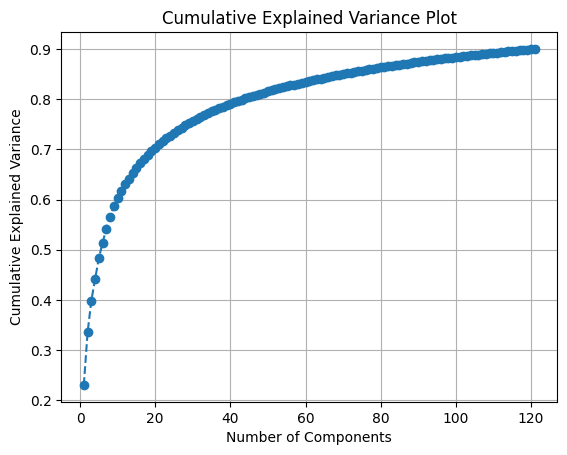

In [ ]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.grid(True)
plt.show()

In [ ]:
# Reassign the variables
X_train = X_train_pca
X_test = X_test_pca

# X_train = X_train
# X_test = X_test

Epoch 1/20
3125/3125 [==============================] - 15s 3ms/step - loss: 0.7250 - accuracy: 0.6273 - val_loss: 0.5490 - val_accuracy: 0.7340
Epoch 2/20
3125/3125 [==============================] - 9s 3ms/step - loss: 0.5555 - accuracy: 0.7102 - val_loss: 0.5102 - val_accuracy: 0.7621
Epoch 3/20
3125/3125 [==============================] - 9s 3ms/step - loss: 0.5307 - accuracy: 0.7333 - val_loss: 0.4892 - val_accuracy: 0.7754
Epoch 4/20
3125/3125 [==============================] - 8s 3ms/step - loss: 0.5122 - accuracy: 0.7490 - val_loss: 0.4727 - val_accuracy: 0.7854
Epoch 5/20
3125/3125 [==============================] - 8s 3ms/step - loss: 0.5033 - accuracy: 0.7565 - val_loss: 0.4641 - val_accuracy: 0.7904
Epoch 6/20
3125/3125 [==============================] - 9s 3ms/step - loss: 0.4944 - accuracy: 0.7605 - val_loss: 0.4663 - val_accuracy: 0.7920
Epoch 7/20
3125/3125 [==============================] - 9s 3ms/step - loss: 0.4889 - accuracy: 0.7665 - val_loss: 0.4703 - val_accuracy

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71794 | val_0_auc: 0.56629 |  0:00:04s
epoch 1  | loss: 0.67102 | val_0_auc: 0.66086 |  0:00:08s
epoch 2  | loss: 0.64527 | val_0_auc: 0.6721  |  0:00:12s
epoch 3  | loss: 0.63666 | val_0_auc: 0.68709 |  0:00:16s
epoch 4  | loss: 0.62037 | val_0_auc: 0.73703 |  0:00:20s
epoch 5  | loss: 0.5905  | val_0_auc: 0.76614 |  0:00:25s
epoch 6  | loss: 0.5604  | val_0_auc: 0.80014 |  0:00:29s
epoch 7  | loss: 0.5279  | val_0_auc: 0.82798 |  0:00:33s
epoch 8  | loss: 0.50121 | val_0_auc: 0.8448  |  0:00:37s
epoch 9  | loss: 0.4801  | val_0_auc: 0.85962 |  0:00:41s
epoch 10 | loss: 0.46176 | val_0_auc: 0.86901 |  0:00:45s
epoch 11 | loss: 0.44942 | val_0_auc: 0.87485 |  0:00:50s
epoch 12 | loss: 0.44062 | val_0_auc: 0.87894 |  0:00:54s
epoch 13 | loss: 0.42958 | val_0_auc: 0.88403 |  0:00:58s
epoch 14 | loss: 0.42106 | val_0_auc: 0.8872  |  0:01:02s
epoch 15 | loss: 0.41576 | val_0_auc: 0.89063 |  0:01:06s
epoch 16 | loss: 0.40934 | val_0_auc: 0.89198 |  0:01:11s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


625/625 [==============================] - 1s 1ms/step

Logistic Regression Classification Report:
              precision    recall  f1-score   support

        Real     0.6722    0.6483    0.6600     10000
        Fake     0.6604    0.6838    0.6719     10000

    accuracy                         0.6661     20000
   macro avg     0.6663    0.6661    0.6659     20000
weighted avg     0.6663    0.6661    0.6659     20000

Random Forest Classification Report:
              precision    recall  f1-score   support

        Real     0.7972    0.7670    0.7818     10000
        Fake     0.7755    0.8049    0.7899     10000

    accuracy                         0.7860     20000
   macro avg     0.7864    0.7859    0.7859     20000
weighted avg     0.7864    0.7860    0.7859     20000


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

        Real     0.7478    0.7454    0.7466     10000
        Fake     0.7462    0.7486    0.7474     10000

    

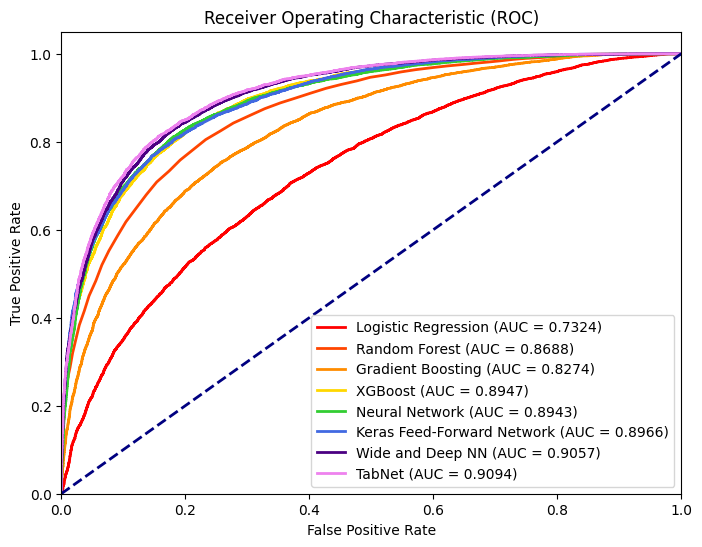

In [ ]:
# Set the random seeds for NumPy, TensorFlow, and PyTorch
np.random.seed(314)
tf.random.set_seed(314)
torch.manual_seed(314)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Initialize and train the Logistic Regression classifier
lr_clf = LogisticRegression(random_state=314)
lr_clf.fit(X_train, y_train)

# Initialize and train the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=314)
rf_clf.fit(X_train, y_train)

# Initialize and train the Gradient Boosting classifier
gb_clf = GradientBoostingClassifier(random_state=314)
gb_clf.fit(X_train, y_train)

# Initialize and train the XGBoost classifier
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

# Initialize and train the Neural Network (MLPClassifier) classifier
nn_clf = MLPClassifier(hidden_layer_sizes=(64,32), activation='relu', solver='adam', max_iter=3000, random_state=314)
nn_clf.fit(X_train, y_train)

# Initialize and train the Keras Sequential model
ffinput_dim = X_train.shape[1]
ffmodel = Sequential()
ffmodel.add(Dense(64, activation='relu', input_shape=(ffinput_dim,)))
ffmodel.add(Dropout(0.5))
ffmodel.add(Dense(32, activation='relu'))
ffmodel.add(Dropout(0.5))
ffmodel.add(Dense(1, activation='sigmoid'))

# Compile the model
ffmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implement early stopping
ffearly_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model
ffmodel.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[ffearly_stopping])

# Initialize and train the Wide and Deep model
wdinput_dim = X_train.shape[1]
wdinput_layer = Input(shape=(wdinput_dim,))
deep = Dense(64, activation='relu')(wdinput_layer)
deep = Dropout(0.5)(deep)
deep = Dense(32, activation='relu')(deep)
deep = Dropout(0.5)(deep)

wide = wdinput_layer  # Copy input
wide = Dense(64, activation='relu')(wide)

# Combine deep and wide components
wdcombined = concatenate([deep, wide])

wdoutput_layer = Dense(1, activation='sigmoid')(wdcombined)

# Create a Wide and Deep Model
wdmodel = Model(inputs=wdinput_layer, outputs=wdoutput_layer)

# Compile the model
wdmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implement early stopping
wdearly_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model
wdmodel.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[wdearly_stopping])

# Create and train a TabNet model
tbclf = TabNetClassifier()
tbclf.fit(X_train, y_train, eval_set=[(X_test, y_test)], patience=10)

# Predict labels on the test set for all classifiers
y_pred_lr = lr_clf.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)
y_pred_gb = gb_clf.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)
y_pred_nn = nn_clf.predict(X_test)
y_pred_keras = ffmodel.predict(X_test)
y_pred_keras = (y_pred_keras > 0.5).astype(int)
y_pred_wide_deep = wdmodel.predict(X_test)
y_pred_wide_deep = (y_pred_wide_deep > 0.5).astype(int)
y_pred_tabnet = tbclf.predict(X_test)
y_pred_tabnet = (y_pred_tabnet > 0.5).astype(int)

# Generate classification reports for all classifiers
class_report_lr = classification_report(y_test, y_pred_lr, target_names=["Real", "Fake"], digits=4)
class_report_rf = classification_report(y_test, y_pred_rf, target_names=["Real", "Fake"], digits=4)
class_report_gb = classification_report(y_test, y_pred_gb, target_names=["Real", "Fake"], digits=4)
class_report_xgb = classification_report(y_test, y_pred_xgb, target_names=["Real", "Fake"], digits=4)
class_report_nn = classification_report(y_test, y_pred_nn, target_names=["Real", "Fake"], digits=4)
class_report_keras = classification_report(y_test, y_pred_keras, target_names=["Real", "Fake"], digits=4)
class_report_wide_deep = classification_report(y_test, y_pred_wide_deep, target_names=["Real", "Fake"], digits=4)
class_report_tabnet = classification_report(y_test, y_pred_tabnet, target_names=["Real", "Fake"], digits=4)

# Print classification reports
print("\nLogistic Regression Classification Report:")
print(class_report_lr)

print("Random Forest Classification Report:")
print(class_report_rf)

print("\nGradient Boosting Classification Report:")
print(class_report_gb)

print("XGBoost Classification Report:")
print(class_report_xgb)

print("\nNeural Network Classification Report:")
print(class_report_nn)

print("Keras Feed-Forward Network Classification Report:")
print(class_report_keras)

print("Wide and Deep Neural Network Classification Report:")
print(class_report_wide_deep)

print("TabNet Classification Report:")
print(class_report_tabnet)

# Calculate ROC curve and AUC for Logistic Regression
y_scores_lr = lr_clf.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_scores_lr)
roc_auc_lr = roc_auc_score(y_test, y_scores_lr)

# Calculate ROC curve and AUC for Random Forest
y_scores_rf = rf_clf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_scores_rf)
roc_auc_rf = roc_auc_score(y_test, y_scores_rf)

# Calculate ROC curve and AUC for Gradient Boosting
y_scores_gb = gb_clf.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_scores_gb)
roc_auc_gb = roc_auc_score(y_test, y_scores_gb)

# Calculate ROC curve and AUC for XGBoost
y_scores_xgb = xgb_clf.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_scores_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_scores_xgb)

# Calculate ROC curve and AUC for the Neural Network
y_scores_nn = nn_clf.predict_proba(X_test)
y_scores_nn = y_scores_nn[:, 1]
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_scores_nn)
roc_auc_nn = roc_auc_score(y_test, y_scores_nn)

# Calculate ROC curve and AUC for Keras
y_scores_keras = ffmodel.predict(X_test)
# fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
# roc_auc_keras = roc_auc_score(y_test, y_pred_keras)

fpr_keras = dict()
tpr_keras = dict()
roc_auc_keras = dict()

fpr_keras, tpr_keras, _ = roc_curve(y_test, y_scores_keras)
roc_auc_keras = roc_auc_score(y_test, y_scores_keras)

# Calculate ROC curve and AUC for Wide and Deep Neural Network
y_scores_wd = wdmodel.predict(X_test)
# fpr_wide_deep, tpr_wide_deep, thresholds_wide_deep = roc_curve(y_test, y_pred_wide_deep)
# roc_auc_wide_deep = roc_auc_score(y_test, y_pred_wide_deep)

fpr_wide_deep = dict()
tpr_wide_deep = dict()
roc_auc_wide_deep = dict()

fpr_wide_deep, tpr_wide_deep, _ = roc_curve(y_test, y_scores_wd)
roc_auc_wide_deep = roc_auc_score(y_test, y_scores_wd)

# Calculate ROC curve and AUC for TabNet
y_scores_tabnet = tbclf.predict_proba(X_test)[:, 1]
fpr_tabnet, tpr_tabnet, thresholds_tabnet = roc_curve(y_test, y_scores_tabnet)
roc_auc_tabnet = roc_auc_score(y_test, y_scores_tabnet)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='red', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
plt.plot(fpr_rf, tpr_rf, color='orangered', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label=f'Gradient Boosting (AUC = {roc_auc_gb:.4f})')
plt.plot(fpr_xgb, tpr_xgb, color='gold', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
plt.plot(fpr_nn, tpr_nn, color='limegreen', lw=2, label=f'Neural Network (AUC = {roc_auc_nn:.4f})')
plt.plot(fpr_keras, tpr_keras, color='royalblue', lw=2, label=f'Keras Feed-Forward Network (AUC = {roc_auc_keras:.4f})')
plt.plot(fpr_wide_deep, tpr_wide_deep, color='indigo', lw=2, label=f'Wide and Deep NN (AUC = {roc_auc_wide_deep:.4f})')
plt.plot(fpr_tabnet, tpr_tabnet, color='violet', lw=2, label=f'TabNet (AUC = {roc_auc_tabnet:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

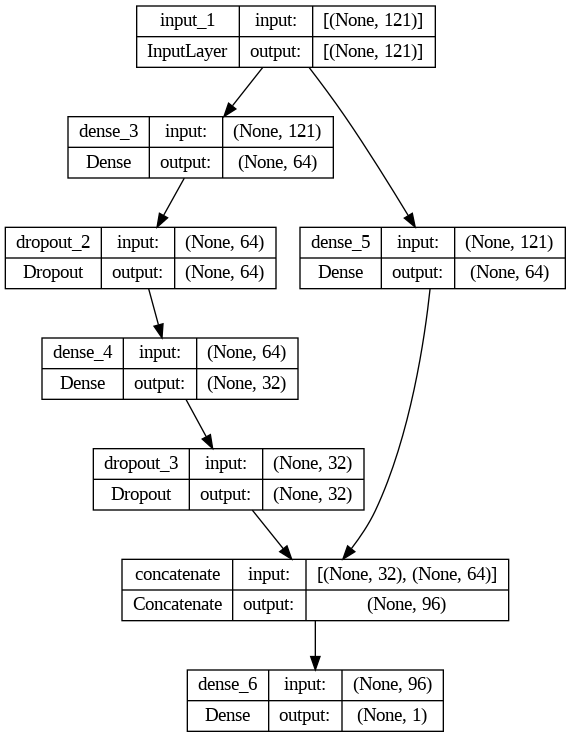

In [ ]:
plot_model(wdmodel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

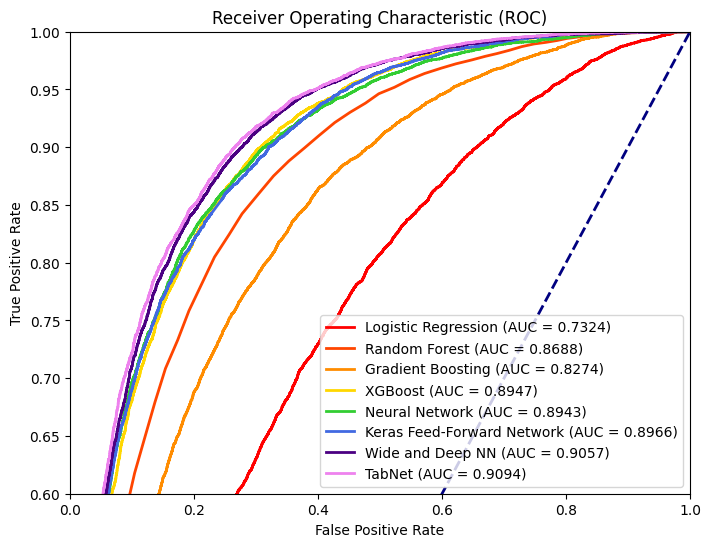

In [ ]:
# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='red', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
plt.plot(fpr_rf, tpr_rf, color='orangered', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label=f'Gradient Boosting (AUC = {roc_auc_gb:.4f})')
plt.plot(fpr_xgb, tpr_xgb, color='gold', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
plt.plot(fpr_nn, tpr_nn, color='limegreen', lw=2, label=f'Neural Network (AUC = {roc_auc_nn:.4f})')
plt.plot(fpr_keras, tpr_keras, color='royalblue', lw=2, label=f'Keras Feed-Forward Network (AUC = {roc_auc_keras:.4f})')
plt.plot(fpr_wide_deep, tpr_wide_deep, color='indigo', lw=2, label=f'Wide and Deep NN (AUC = {roc_auc_wide_deep:.4f})')
plt.plot(fpr_tabnet, tpr_tabnet, color='violet', lw=2, label=f'TabNet (AUC = {roc_auc_tabnet:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set the limits to focus on the area between 0.20 FPR and 0.40 TPR
plt.xlim([0.0, 1])
plt.ylim([0.6, 1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
wdmodel.save('/content/widedeepclassifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
